In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import numpy as np
import os
import ast
from skimage.morphology import skeletonize


def to_tuple(t):
    return ast.literal_eval(t)
 
def unique_color(img):
    mask = img > 0
    only_color = img[mask]
    colors, count = np.unique(only_color, return_counts=True)
    max_color = colors[count.argmax()]
    #print(max_color)
    img[np.logical_not(mask)] = max_color
    return img

def maxDeviationThresh(hist):
    maximum = max(hist)
    index_max = list(hist).index(maximum)
    index_min = 0
    for i in range(0, index_max):
        if not hist[i] and hist[i + 1]:
            index_min = i
            break

    distances = []
    x1 = index_min
    y1 = hist[index_min]
    x2 = index_max
    y2 = hist[index_max]
    for i in range(index_min + 1, index_max):
        x0 = i
        y0 = hist[i]
        distance = np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1) / np.sqrt(
            (y2 - y1) ** 2 + (x2 - x1) ** 2)
        distances.append(distance)
    if index_min < index_max - 1:
        T_index = distances.index(max(distances))
    else:
        T_index = -index_min
    return T_index + index_min


def extract_drawing(image):
    dst = cv2.bilateralFilter(image, 10, sigmaColor=15, sigmaSpace=15)
    # dst = img.copy()
    # max_occ = np.bincount(dst[dst > 0]).argmax()
    # dst[dst == 0] = max_occ
    threshed = np.ones(dst.shape, np.uint8) * 255
    if np.any(dst < 255):
        hist, _ = np.histogram(dst[dst < 255].flatten(), range(257))
        thresh_val = maxDeviationThresh(hist)
        #print(thresh_val)
        mask = dst < thresh_val
        threshed[mask] = 0
    return threshed

def getBackground(external, img, morph=True, ret_hier=False):
    background = np.zeros_like(img)
    points = np.array([external]).reshape((4, 1, 2))
    background = cv2.fillConvexPoly(background, points, (255, 255, 255))
    background = cv2.bitwise_and(img, background)
    overlap = cv2.polylines(cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2RGB), [points], True, (255, 0, 0), 1)
    #plt.imshow(overlap)
    #plt.show()
    background[background == 0] = 255
    background = extract_drawing(background)
    if morph:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        # background = cv2.bitwise_not(background)
        background = cv2.bitwise_not(cv2.erode(background, kernel))
        background = skeletonize(background / 255, method='lee').astype(np.uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        background = cv2.dilate(background, kernel)
    else:
        background = cv2.bitwise_not(background)
        background = skeletonize(background / 255, method='lee').astype(np.uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        background = cv2.dilate(background, kernel)
    #plt.imshow(background, cmap='gray')
    #plt.show()
    cnts, hier = cv2.findContours(background, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if ret_hier:
        return background, cnts, hier
    else:
        return background, cnts

In [3]:


root = './gdrive/My Drive/thesis' #modificare se cartella rinominata
df_rail = pd.read_csv(os.path.join(root, 'scores_23_uniti.csv'), header=0, usecols=['names', 'rect'], index_col='names', converters={'rect': to_tuple})
plt.rcParams['figure.figsize'] = [10, 5]
pixels = []

dataset = pd.read_csv(os.path.join(root, 'Database completo .csv'), header=0, index_col=0, delimiter=';')
linee_d = dataset.loc[:, 'PATTERN18'] #cambiare qui
print(linee_d.value_counts())
scoring=np.zeros(4)
hom_folder = os.path.join(root, 'omografie')
file_homog = pd.read_json(os.path.join(hom_folder, 'list.txt'), lines=True).set_index('name')

coords = [852, 229, 1031, 531]#cambiare qui
y_data = []
X = [] 
i = 3 #cambiare qui
for img_path in os.listdir(hom_folder):
    if img_path.endswith('.png'):
      name = img_path.split('_')[-1][:-4]      
      if name in linee_d.index:
        score = int(linee_d.loc[name])       
        scoring[score] += 1
        if score == 0:
          y_data.append(0)
          img = unique_color(cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_GRAYSCALE))
          img = cv2.blur(img, (5, 5))
          if img_path[:-4] in df_rail.index:
            rail_bbox = df_rail.loc[img_path[:-4]].values[0][i]
            external = [(rail_bbox[0], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]+rail_bbox[3]), (rail_bbox[0], rail_bbox[1]+rail_bbox[3])]
            background, _ = getBackground(external, img, False)
            pixel = np.sum(np.divide(background, 255))
            print('pixels {}'.format(pixel))
            img = cv2.rectangle(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), (rail_bbox[0], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]+rail_bbox[3]), (255,0,0), 3)
            X.append([1, pixel])
          else:
            x = coords[0] 
            y = coords[1] 
            w = np.abs(coords[0] - coords[2])
            h = np.abs(coords[1] - coords[3])
            external = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]
            background, _ = getBackground(external, img, False)
            pixel = np.sum(np.divide(background, 255))
            print('pixels {}'.format(pixel))
            X.append([0, pixel])
          
        else:
          y_data.append(1)
          img = unique_color(cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_GRAYSCALE))
          img = cv2.blur(img, (5, 5))
          if img_path[:-4] in df_rail.index:
            rail_bbox = df_rail.loc[img_path[:-4]].values[0][i]
            external = [(rail_bbox[0], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]+rail_bbox[3]), (rail_bbox[0], rail_bbox[1]+rail_bbox[3])]
            background, _ = getBackground(external, img, False)
            pixel = np.sum(np.divide(background, 255))
            X.append([1, pixel])
          else:
            x = coords[0] 
            y = coords[1] 
            w = np.abs(coords[0] - coords[2])
            h = np.abs(coords[1] - coords[3])
            external = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]
            background, _ = getBackground(external, img, False)
            pixel = np.sum(np.divide(background, 255))
            print('pixels {}'.format(pixel))
            X.append([0, pixel])

hom_folder = os.path.join(root, 'homog_brutte')
file_homog = pd.read_json(os.path.join(hom_folder, 'list_brutte.txt'), lines=True).set_index('name')
   
for img_path in os.listdir(hom_folder):  
    if img_path.endswith('.png'):
      name = img_path.split('_')[-1][:-4]      
      if name in linee_d.index:
        score = int(linee_d.loc[name])        
        scoring[score] += 1
        if score == 0:
          y_data.append(0)
          img = unique_color(cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_GRAYSCALE))
          img = cv2.blur(img, (5, 5))
          if img_path[:-4] in df_rail.index:
            rail_bbox = df_rail.loc[img_path[:-4]].values[0][i]
            external = [(rail_bbox[0], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]+rail_bbox[3]), (rail_bbox[0], rail_bbox[1]+rail_bbox[3])]
            background, _ = getBackground(external, img, False)
            pixel = np.sum(np.divide(background, 255))
            print('pixels {}'.format(pixel))
            img = cv2.rectangle(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), (rail_bbox[0], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]+rail_bbox[3]), (255,0,0), 3)
            X.append([1, pixel])
          else:
            x = coords[0] 
            y = coords[1] 
            w = np.abs(coords[0] - coords[2])
            h = np.abs(coords[1] - coords[3])
            external = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]
            background, _ = getBackground(external, img, False)
            pixel = np.sum(np.divide(background, 255))
            print('pixels {}'.format(pixel))
            X.append([0, pixel])
          
        else:
          img = unique_color(cv2.imread(os.path.join(hom_folder, img_path), cv2.IMREAD_GRAYSCALE))
          img = cv2.blur(img, (5, 5))
          y_data.append(1)
          if img_path[:-4] in df_rail.index:
            rail_bbox = df_rail.loc[img_path[:-4]].values[0][i]
            external = [(rail_bbox[0], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]), (rail_bbox[0]+rail_bbox[2], rail_bbox[1]+rail_bbox[3]), (rail_bbox[0], rail_bbox[1]+rail_bbox[3])]
            background, _ = getBackground(external, img, False)
            pixel = np.sum(np.divide(background, 255))
            X.append([1, pixel])
          else:
            x = coords[0] 
            y = coords[1] 
            w = np.abs(coords[0] - coords[2])
            h = np.abs(coords[1] - coords[3])
            external = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]
            background, _ = getBackground(external, img, False)
            pixel = np.sum(np.divide(background, 255))
            print('pixels {}'.format(pixel))
            X.append([0, pixel])
print(scoring)
X = np.array(X)
y = np.array(y_data)
print(X.shape, y.shape)
          



3    125
1     84
0     27
Name: PATTERN18, dtype: int64
pixels 2414.0
pixels 30.0
pixels 1316.0
pixels 1888.0
pixels 2352.0
pixels 82.0
pixels 1843.0
pixels 3141.0
pixels 103.0
pixels 5769.0
pixels 279.0
pixels 1446.0
pixels 2738.0
pixels 18.0
pixels 1000.0
pixels 2022.0
pixels 507.0
pixels 610.0
pixels 1967.0
pixels 1220.0
pixels 1835.0
pixels 1646.0
pixels 65.0
pixels 4179.0
[ 24.  80.   0. 119.]
(223, 2) (223,)


[[2.988e+03 1.000e+00]
 [2.422e+03 1.000e+00]
 [2.043e+03 1.000e+00]
 [3.653e+03 1.000e+00]
 [3.117e+03 1.000e+00]
 [1.530e+03 1.000e+00]
 [2.264e+03 1.000e+00]
 [2.640e+03 1.000e+00]
 [2.692e+03 1.000e+00]
 [2.039e+03 1.000e+00]
 [7.231e+03 1.000e+00]
 [2.549e+03 1.000e+00]
 [2.504e+03 1.000e+00]
 [2.915e+03 1.000e+00]
 [3.881e+03 1.000e+00]
 [2.695e+03 1.000e+00]
 [2.871e+03 1.000e+00]
 [2.999e+03 1.000e+00]
 [3.086e+03 1.000e+00]
 [3.604e+03 1.000e+00]
 [2.709e+03 1.000e+00]
 [2.720e+03 1.000e+00]
 [2.932e+03 1.000e+00]
 [2.763e+03 1.000e+00]
 [2.414e+03 0.000e+00]
 [1.750e+03 1.000e+00]
 [2.325e+03 1.000e+00]
 [1.432e+03 1.000e+00]
 [2.317e+03 1.000e+00]
 [2.401e+03 1.000e+00]
 [3.020e+03 1.000e+00]
 [1.267e+03 1.000e+00]
 [6.535e+03 1.000e+00]
 [2.618e+03 1.000e+00]
 [1.519e+03 1.000e+00]
 [2.740e+03 1.000e+00]
 [3.307e+03 1.000e+00]
 [2.808e+03 1.000e+00]
 [2.497e+03 1.000e+00]
 [2.804e+03 1.000e+00]
 [2.876e+03 1.000e+00]
 [3.310e+03 1.000e+00]
 [2.521e+03 1.000e+00]
 [3.943e+03

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


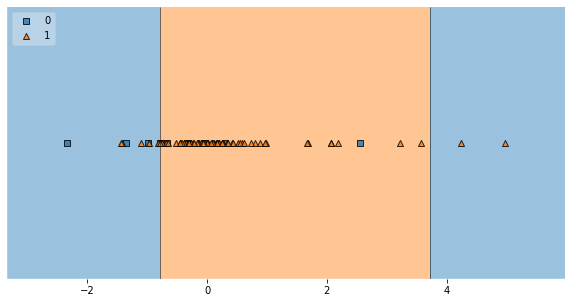

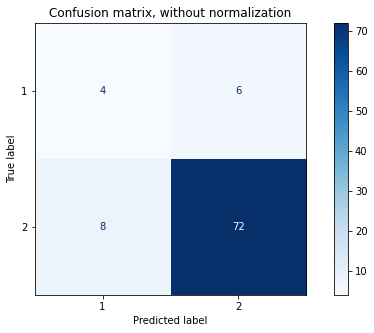

Normalized confusion matrix
[[0.4 0.6]
 [0.1 0.9]]


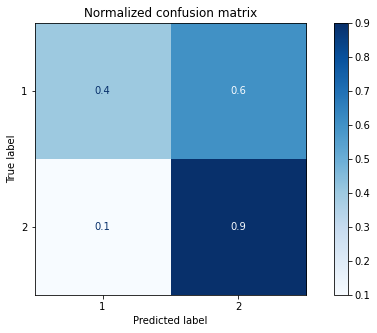

SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8914855072463768
train score: 0.8823529411764706
test score: 0.65625

cv score: 0.8914855072463768
train score: 0.9022556390977443
test score: 0.8555555555555555

Confusion matrix, without normalization
[[ 4  6]
 [ 7 73]]


/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


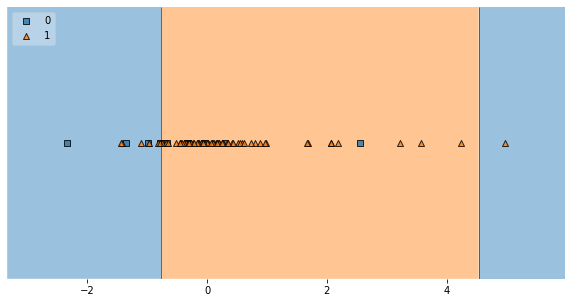

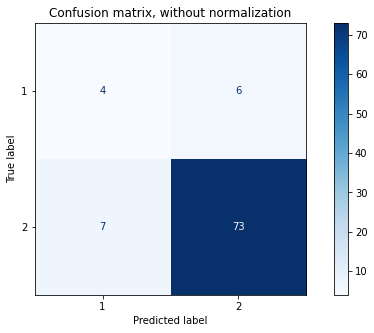

Normalized confusion matrix
[[0.4    0.6   ]
 [0.0875 0.9125]]


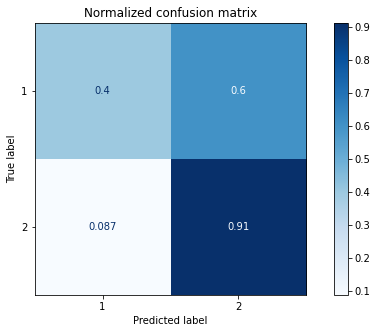

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cv score: 0.8748188405797102
train score: 0.8823529411764706
test score: 0.65625

cv score: 0.8748188405797102
train score: 0.9022556390977443
test score: 0.8555555555555555

Confusion matrix, without normalization
[[ 4  6]
 [ 7 73]]


/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


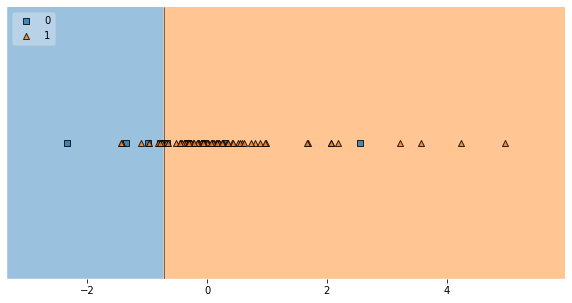

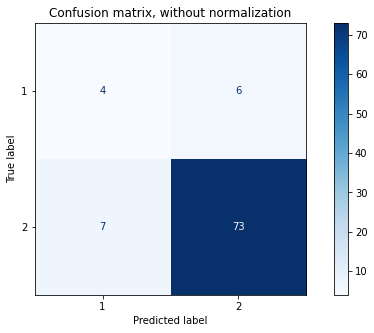

Normalized confusion matrix
[[0.4    0.6   ]
 [0.0875 0.9125]]


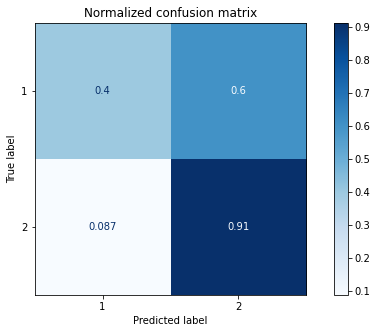

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions

X_pixel = X[:, 1].reshape(-1,1)
print(np.concatenate([X_pixel, np.expand_dims(y, axis=1)], axis=1))          
X_train, X_test, y_train, y_test = train_test_split(X_pixel, y, test_size=0.4, random_state=0, stratify=y)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
      'coef0': np.linspace(-10, 10, 5),
      'degree': [2, 3, 4]}
svm_poly_pixel = GridSearchCV(SVC(kernel='poly', class_weight='balanced'), param_grid,
                        cv=5, scoring='balanced_accuracy', refit=True)
svm_poly_pixel.fit(X_train_scaled, y_train)
print('poly done')
# RBF
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
rbf_poly_pixel = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, 
                        cv=5, scoring='balanced_accuracy', refit=True)
rbf_poly_pixel.fit(X_train_scaled, y_train)
print('rbf done')
# Sigmoid
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'coef0': np.linspace(-10, 10, 5)}
sigm_poly_pixel = GridSearchCV(SVC(kernel='sigmoid', class_weight='balanced'), param_grid, 
                        cv=5, scoring='balanced_accuracy', refit=True)
sigm_poly_pixel.fit(X_train_scaled, y_train)
print('sigmoid done')
for m in [svm_poly_pixel, rbf_poly_pixel, sigm_poly_pixel]:
    cv_score = m.best_score_
    m = m.best_estimator_    
    print(m)     
    train_acc = balanced_accuracy_score(y_train, m.predict(X_train_scaled))
    test_acc = balanced_accuracy_score(y_test, m.predict(X_test_scaled))
    print("cv score: {}".format(cv_score))
    print("train score: {}".format(train_acc))
    print("test score: {}\n".format(test_acc))
    train_acc = accuracy_score(y_train, m.predict(X_train_scaled))
    test_acc = accuracy_score(y_test, m.predict(X_test_scaled))
    print("cv score: {}".format(cv_score))
    print("train score: {}".format(train_acc))
    print("test score: {}\n".format(test_acc))
    plot_decision_regions(X_test_scaled, y_test, clf=m, legend=2)
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    class_names = ['1', '2']
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(m, X_test_scaled, y_test,
                                    display_labels=class_names,
                                    cmap=plt.cm.Blues,
                                    normalize=normalize)
        disp.ax_.set_title(title)
        print(title)
        print(disp.confusion_matrix)
        plt.show()
        plt.close('all')

In [5]:
import joblib
joblib.dump(rbf_poly_pixel.best_estimator_, 'gdrive/My Drive/cross_v_model.joblib')
joblib.dump(scaler, 'gdrive/My Drive/cross_vert_scaler.joblib')

['gdrive/My Drive/cross_vert_scaler.joblib']